<a href="https://colab.research.google.com/github/YuvanBharathi13/DeepLearning/blob/main/Food_Vission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOOD VISION

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-092aead5-35aa-bb4e-0c7e-ee64b5a8de33)


## Mixed Precision

- In this project we will be using Mixed precision.
- Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory.
- Mixed precsion can run on any hardware but it will only speed up models on recent NVIDIA GPUs which have a compute power greater or equal to 7.0.
- lucky for us, colab gives access to NVIDIA T4 GPU which has a compute power of 7.5. yayyy!!!

## Helper functions

- These are the function we would be using throughout the project

In [3]:
def plot_curves(history):
  loss_train = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)

  plt.plot(epochs,loss_train,'r',label='Training Loss')
  plt.plot(epochs,val_loss,'b',label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)

  plt.plot(epochs,accuracy,'r',label='Training Accuracy')
  plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [4]:
def compare_historys(original_history, new_history, initial_epochs=5):
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Downloading Dataset

- For this project we will be working on the food101 dataset from tensorflow datasets.
- it is a dataset that contains data for 101 food classes with each class having 750 training images and 250 testing images.

In [5]:
import tensorflow_datasets as tfds

In [37]:
(train_data,test_data), ds_info = tfds.load(name='food101',
                                            split=['train','validation'],
                                            shuffle_files=True, # shuffles the images as it downloads
                                            as_supervised=True, # the dataset will come with the labels (data,label)
                                            with_info=True) # we are downloading the meta data as well

## Exploring the Dataset

- Questions that need to be asked -
  1. The shape of our input data (image tensors)
  2. The datatype of our input data
  3. What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
  4. Do the labels match up with the class names?

In [38]:
print(type(train_data))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
class_names = ds_info.features['label'].names
class_names[10:20]

['bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [10]:
print('pizza' in class_names)

True


In [11]:
train_data.element_spec # The reason why our image size is (none,none,3) is because they all dont have the same shape

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [12]:
sample_image_tuple = train_data.take(1)
sample_image_tuple # will return a random image each time you run it

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
# uint8 stands for unsigned 8-bit integer. It’s a data type commonly used to represent image pixel values.

In [14]:
import matplotlib.image as mpimg

(341, 512, 3)
<dtype: 'uint8'>
tf.Tensor(98, shape=(), dtype=int64)
tiramisu


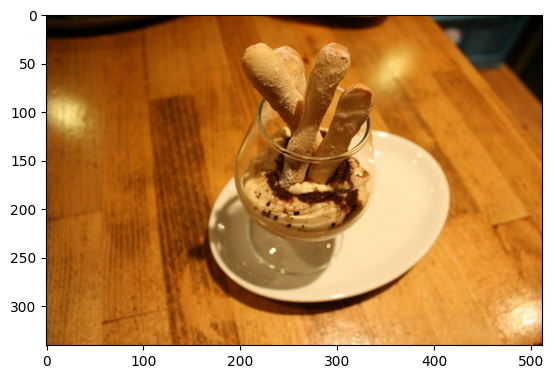

In [15]:
for image, label in sample_image_tuple:
  print(image.shape)
  print(image.dtype)
  print(label)
  print(class_names[label.numpy()]) # since it is tensor we convert it to a numpy variable
  plt.imshow(image)
  plt.show()

In [16]:
image # all values between 0-255

<tf.Tensor: shape=(341, 512, 3), dtype=uint8, numpy=
array([[[  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0],
        ...,
        [  0,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  2,   2,   0],
        [  2,   2,   0],
        [  3,   3,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  5,   6,   1],
        [  5,   6,   1],
        [  5,   6,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   5,   1]],

       ...,

       [[143,  75,  10],
        [149,  81,  16],
        [150,  85,  19],
        ...,
        [162,  88,  25],
        [150,  79,  17],
        [135,  65,   5]],

       [[144,  76,  11],
        [152,  84,  19],
        [145,  80,  16],
        ...,
        [126,  60,  12],
        [111,  50,   3],
        [ 95,  37,   0]],

       [[145,  77,  14],
        [150,  82,  19],
        [139,  74,  10],
        ...,
        [ 89,  35,   

## Data pre-processing

- Things we need to change in our dataset
  1. Our data is not scaled so we need to scale it
  2. The datatype has to be in float as models perform better on it and our current dtype is uint8.
  3. The train and test data are not in batches, so they need to be wrapped in batches
  4. and all the images have different shapes so we need to make then into (224,224,3)

In [26]:
def pre_process_img(image,label,img_shape=224):
  image = tf.image.resize(image,[img_shape,img_shape])
  image = image/255.
  return tf.cast(image,tf.float32),label

Shape of the image before was (384, 512, 3)
Datatype of the image before was <dtype: 'uint8'>
Shape of the image is (224, 224, 3)
Datatype of the image is <dtype: 'float32'>


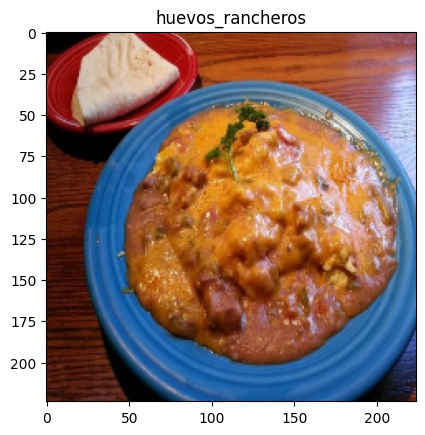

In [27]:
for image, label in sample_image_tuple:
  print(f"Shape of the image before was {image.shape}")
  print(f"Datatype of the image before was {image.dtype}")
  image, label = pre_process_img(image,label)
  print(f"Shape of the image is {image.shape}")
  print(f'Datatype of the image is {image.dtype}')
  plt.imshow(image)
  plt.title(class_names[label.numpy()])

## Batch and prepare dataset

In [39]:
# Train data
train_data = train_data.map(map_func=pre_process_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Test data
test_data = test_data.map(map_func=pre_process_img,num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating callbacks

In [42]:
path = 'model_check_point/feature_extraction_model.keras'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(path,
                                                      monitor='val_acc',
                                                      save_best_only=True,
                                                      save_weights_only=False,
                                                      save_freq='epoch')

## Set up mixed precision training

mixed precision uses a combination of float16 and float32 to speed up the model.

In [43]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')